In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:

# Load the train and test datasets
train_dataset = pd.read_csv('Google_Stock_Price_Train.csv')
test_dataset = pd.read_csv('Google_Stock_Price_Test.csv')


In [32]:
# Inspect the dataset
print("Dataset Preview:")
print(train_dataset.head())

print(train_dataset.dtypes)

print("\nDataset Info:")
print(train_dataset.info())

# Check for missing values
print("\nMissing Values:")
print(train_dataset.isnull().sum())

Dataset Preview:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None

Missing Values:
Date      0
Open      0
High     

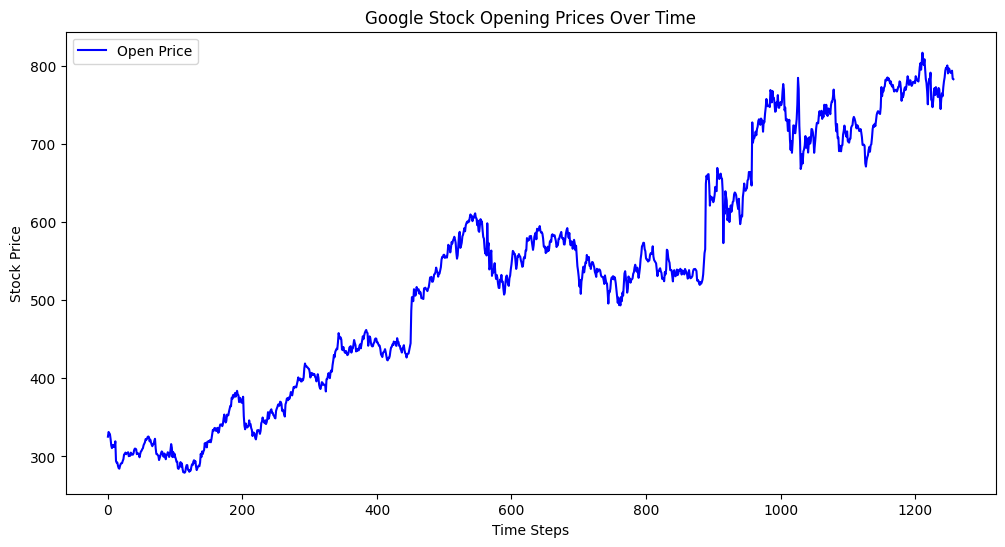

In [33]:
#Visualize the 'Open' prices in the training dataset over time
plt.figure(figsize=(12, 6))
plt.plot(train_dataset['Open'], label='Open Price', color='blue')
plt.title("Google Stock Opening Prices Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [34]:


# Define numerical columns for preprocess
num_columns = ['Open', 'High', 'Low', 'Close', 'Volume']


# Clean and convert columns (i.e., they contain strings)
# if columns contain string values i.e. commas in number cleaning them to numeric

for col in num_columns:
    if train_dataset[col].dtype == 'object':  # Check if column is string
        train_dataset[col] = train_dataset[col].str.replace(',', '').astype(float)
    if test_dataset[col].dtype == 'object':  # Check if column is string
        test_dataset[col] = test_dataset[col].str.replace(',', '').astype(float)



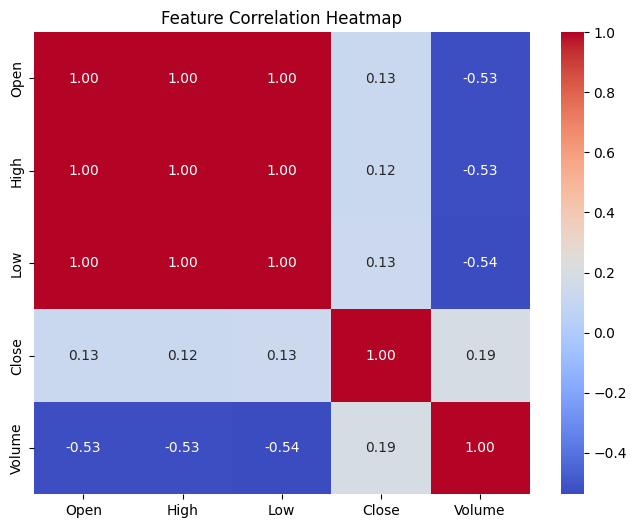

In [35]:
import seaborn as sns
# Visualize correlations between features to understand relationships
correlation_matrix = train_dataset[num_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [36]:

# Normalize features by using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_dataset[num_columns])
test_scaled = scaler.transform(test_dataset[num_columns])


In [37]:
# Define sequence creation function
def create_sequences(data, sequence_length, target_index):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Use the past `sequence_length` rows as input
        y.append(data[i, target_index])  # Target is the value at `target_index`
    return np.array(X), np.array(y)

In [38]:
# Set sequence length and target index
sequence_length = 30
target_index = 3  # for 'Close' price

# Create sequences for training
X_train_full, y_train_full = create_sequences(train_scaled, sequence_length, target_index)

# Spliting training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# prepare test data by Combine last `sequence_length` rows of training data with test data for testing
combined_data = np.vstack((train_scaled[-sequence_length:], test_scaled))
X_test, y_test = create_sequences(combined_data, sequence_length, target_index)


print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (982, 30, 5)
X_val shape: (246, 30, 5)
X_test shape: (20, 30, 5)
y_train shape: (982,)
y_val shape: (246,)
y_test shape: (20,)


In [39]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.3)) #for overfitting
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')#Mean Squared Error loss

# Training LSTM model
lstm_history = lstm_model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=32,verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0296 - val_loss: 0.0063
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0029 - va

In [40]:

# Evaluate LSTM model
lstm_loss = lstm_model.evaluate(X_test, y_test, verbose=1)
lstm_pred = lstm_model.predict(X_test).flatten()

# Compute LSTM metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print(f"LSTM Loss: {lstm_loss}, RMSE: {lstm_rmse}, MAE: {lstm_mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.5373e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
LSTM Loss: 0.0006537294830195606, RMSE: 0.025568133266859496, MAE: 0.021011874417471897


In [41]:
# Define GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(1))
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train GRU model
gru_history = gru_model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=32,verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0619 - val_loss: 0.0020
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0040 - val_loss: 9.7131e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0029 - val_loss: 8.6656e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0025 - val_loss: 9.1131e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0028 - val_loss: 5.2931e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0026 - val_loss: 6.0496e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0027 - val_loss: 6.3196e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0020 - val_loss: 6.2618e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69

In [42]:

# Evaluate GRU model
gru_loss = gru_model.evaluate(X_test, y_test, verbose=1)
gru_pred = gru_model.predict(X_test).flatten()

# Compute GRU metrics
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_mae = mean_absolute_error(y_test, gru_pred)
print(f"GRU Loss: {gru_loss}, RMSE: {gru_rmse}, MAE: {gru_mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3134e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
GRU Loss: 0.0001313423999818042, RMSE: 0.0114604716552938, MAE: 0.008498012045029956


In [43]:
# Compute metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_mae = mean_absolute_error(y_test, gru_pred)


# Print results
print(f"LSTM Loss: {lstm_loss}, RMSE: {lstm_rmse}, MAE: {lstm_mae}")
print(f"GRU Loss: {gru_loss}, RMSE: {gru_rmse}, MAE: {gru_mae}")


LSTM Loss: 0.0006537294830195606, RMSE: 0.025568133266859496, MAE: 0.021011874417471897
GRU Loss: 0.0001313423999818042, RMSE: 0.0114604716552938, MAE: 0.008498012045029956


In [44]:
# Define metrics
data = {
    'Model': ['LSTM', 'GRU'],
    'Test Loss (MSE)': [lstm_loss, gru_loss],  # Replace with actual loss values
    'RMSE': [lstm_rmse, gru_rmse],
    'MAE': [lstm_mae, gru_mae]
}

# Create a DataFrame
comparison_table = pd.DataFrame(data)

# Display the table
print("\nComparison Table:")
print(comparison_table)


Comparison Table:
  Model  Test Loss (MSE)      RMSE       MAE
0  LSTM         0.000654  0.025568  0.021012
1   GRU         0.000131  0.011460  0.008498


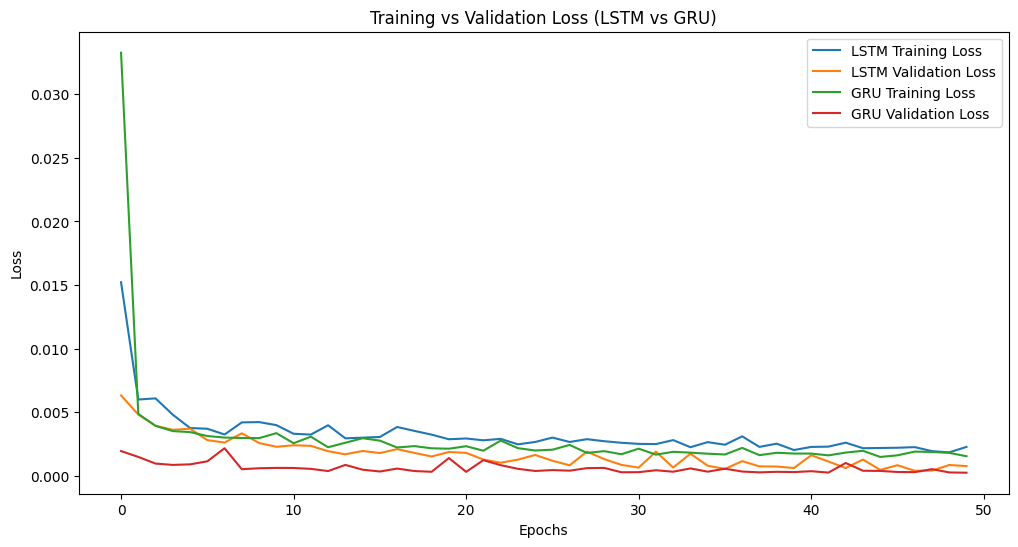

In [45]:
# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('Training vs Validation Loss (LSTM vs GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


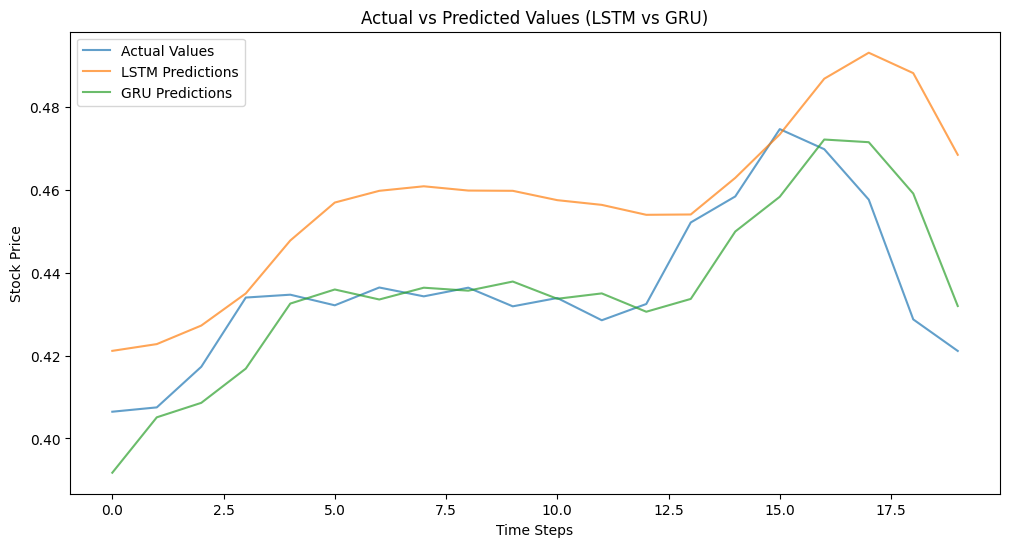

In [46]:
# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=0.7)
plt.plot(lstm_pred, label='LSTM Predictions', alpha=0.7)
plt.plot(gru_pred, label='GRU Predictions', alpha=0.7)
plt.title('Actual vs Predicted Values (LSTM vs GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

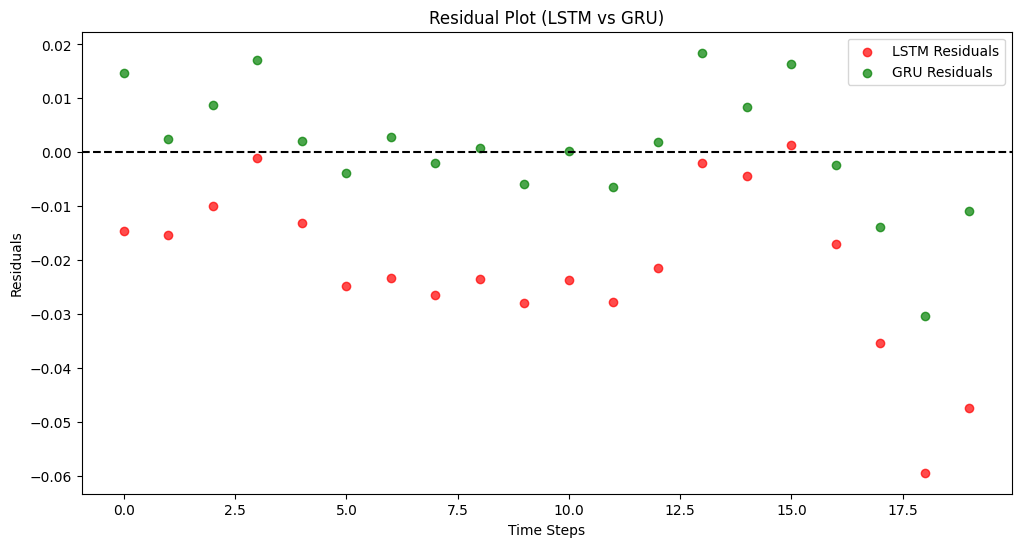

In [47]:
# residuals for LSTM
lstm_residuals = y_test - lstm_pred

# residuals for GRU
gru_residuals = y_test - gru_pred

plt.figure(figsize=(12, 6))
plt.scatter(range(len(lstm_residuals)), lstm_residuals, label='LSTM Residuals', alpha=0.7, color='red')
plt.scatter(range(len(gru_residuals)), gru_residuals, label='GRU Residuals', alpha=0.7, color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Plot (LSTM vs GRU)")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.show()


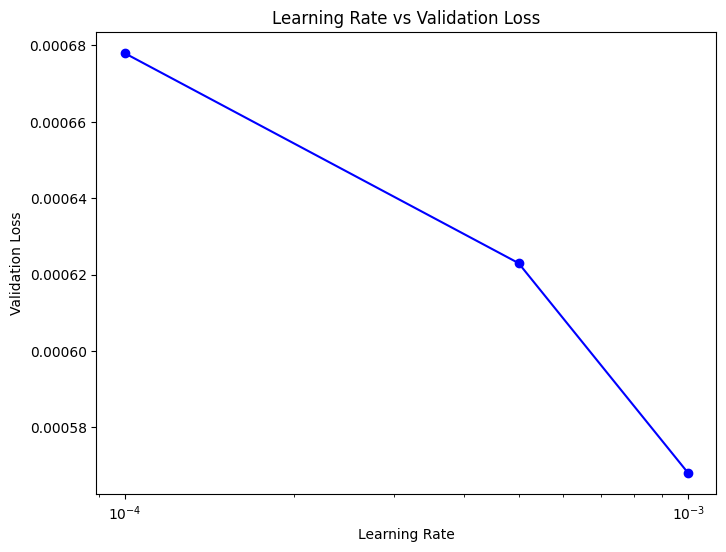

In [48]:
# Assuming `results` contains validation loss for each learning rate
learning_rates = [0.001, 0.0005, 0.0001]
val_losses = [0.000568, 0.000623, 0.000678]  # Replace with actual validation loss values

plt.figure(figsize=(8, 6))
plt.plot(learning_rates, val_losses, marker='o', linestyle='-', color='blue')
plt.title("Learning Rate vs Validation Loss")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.xscale('log')  # Use log scale for learning rates
plt.show()
